In [71]:
import ids_peak.ids_peak as ids_peak
import ids_peak_ipl.ids_peak_ipl as ids_ipl
import ids_peak.ids_peak_ipl_extension as ids_ipl_extension
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt

ids_peak.Library.Initialize()
device_manager = ids_peak.DeviceManager.Instance()
device_manager.Update()
device_descriptors = device_manager.Devices()

print("Found Devices: " + str(len(device_descriptors)))
for device_descriptor in device_descriptors:
    print(device_descriptor.DisplayName())

Found Devices: 1
IDS Imaging Development Systems GmbH U3-327xCP-M (1409f4e761f0U3-327xCP-M-0)


Open Device

In [72]:
device = device_descriptors[0].OpenDevice(ids_peak.DeviceAccessType_Control)
print("Opened Device: " + device.DisplayName())
remote_device_nodemap = device.RemoteDevice().NodeMaps()[0]

BadAccessException: Error-Code: 4 (PEAK_RETURN_CODE_BAD_ACCESS) | Error-Description: [Function: IFOpenDevice | Error-Code: -1004 (GC_ERR_RESOURCE_IN_USE) | Error-Text: Module 1409f4e761f0U3-327xCP-M-0 is open already!

Set software trigger

In [59]:
remote_device_nodemap.FindNode("TriggerSelector").SetCurrentEntry("ExposureStart")
remote_device_nodemap.FindNode("TriggerSource").SetCurrentEntry("Software")
remote_device_nodemap.FindNode("TriggerMode").SetCurrentEntry("On")

Start Image Acquisition

In [60]:
datastream = device.DataStreams()[0].OpenDataStream()
payload_size = remote_device_nodemap.FindNode("PayloadSize").Value()
for i in range(datastream.NumBuffersAnnouncedMinRequired()):
    buffer = datastream.AllocAndAnnounceBuffer(payload_size)
    datastream.QueueBuffer(buffer)
    
datastream.StartAcquisition()
remote_device_nodemap.FindNode("AcquisitionStart").Execute()
remote_device_nodemap.FindNode("AcquisitionStart").WaitUntilDone()

Set exposure


In [61]:
exposure_time_seg = 1/125
exposure_time_microseg = exposure_time_seg * 1e6

remote_device_nodemap.FindNode("ExposureTime").SetValue(exposure_time_microseg) # in microseconds  


Grab 1 Image

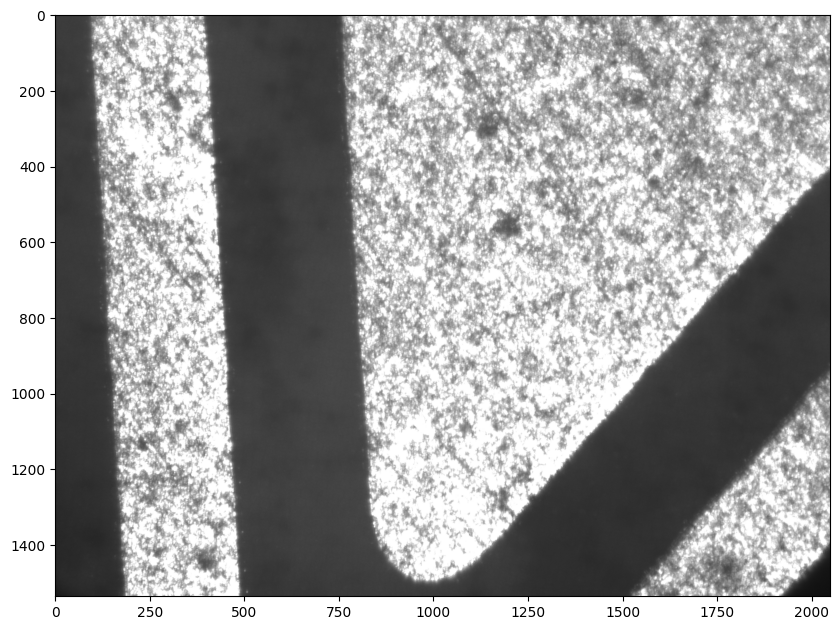

In [123]:
# trigger image
remote_device_nodemap.FindNode("TriggerSoftware").Execute()
buffer = datastream.WaitForFinishedBuffer(1000)

# convert to RGB
raw_image = ids_ipl_extension.BufferToImage(buffer)
# for Peak version 2.0.1 and lower, use this function instead of the previous line:
#raw_image = ids_ipl.Image_CreateFromSizeAndBuffer(buffer.PixelFormat(), buffer.BasePtr(), buffer.Size(), buffer.Width(), buffer.Height())
color_image = raw_image.ConvertTo(ids_ipl.PixelFormatName_RGB8)
datastream.QueueBuffer(buffer)

picture = color_image.get_numpy_3D()

# display the image
plt.figure(figsize = (10,10))

plt.imshow(picture)

timestamp = dt.datetime.now()
plt.savefig(f'img/img_{timestamp.strftime("%Y%m%d_%H%M%S")}.png')

Histograma


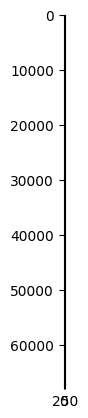

In [ ]:
import cv2
gray_image = cv2.cvtColor(picture, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, cmap='gray')

plt.xlim([0, 256])
hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
plt.plot(hist, color="Black")

Manipular Imagen

Cerrar cámaras

In [64]:
ids_peak.Library.Close()